# COVID Tweets - Sentiment Analysis and Trends 

## AML 2304_1 - Natural Language Processing
### Team Members:
<ul>
    <li>Neelesh Vashist – C0858518</li>
    <li>Rohit Kumar – C0859060</li>
    <li>Mukul Bisht – C0857928</li>
    <li>Saurabh Singh – C0859334</li>
</ul>

### Abstract
This notebook presents novel results of COVID sentiment analysis with concrete findings. We use off-the-shelf libraries with functional limitations, but overall results seem valid based on our analysis. For this project, we are using Vader and TextBlob for our analysis.

### Introduction
The worldwide coronavirus pandemic has led to the establishment of worldwide curfews, quarantines and lockdown to mitigate further spread of the virus. During this time, it can be helpful to track the public's responses to these changes. This study aims to answer the following questions: 
1. How do people feel during the crisis? 
2. How does the general public sentiment change over time? 
3. What are the topics that most contribute to this sentiment shift? 

We filtered the data to only include tweets in English for ease of study. This section summarizes the result with a few graphs generated by the code in the latter section of the notebook. 

### Sentiment Analysis
During the COVID pandemic, [sentiment Analysis](https://monkeylearn.com/sentiment-analysis/) can be a very useful tool to help policymakers gain insight into social media data trends. Normally, sentiment analysis requires training an ML model using labelled data. However, since we don't have training data in this dataset, we opt to use pre-training modeled from the "TextBlob" package and "Vader" Package. Although not a state-of-the-art model, it gives reasonable results.

From the graphs of Sentiment over Time, we notice that: 
* The overall sentiment increased in positivity by about 4% throughout the month of April, while tweet volume decreased slightly. This may reflect gradual subsiding of initial panic.
* The end of April saw a positivity spike of about 2%, which occurs right before re-opening in the USA. This boosted sentiment may be caused by an increase in morale attributed to the re-opening policy decision.


### What could be improved: 
* Better sentiment analysis tool. TextBlob sentiment analysis has a [pre-trained model](https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) that uses nltk's NaiveBayesClassifier, which does not account for sentence structure. Also, the model is trained on movie review data, which may have reduced performance when used on Twitter data. 
* Error rate for the sentiment analysis step is unknown. To measure the error rate, we may label a small (~1000s of tweets) validation data set to test the model. 
* This study did not factor in the country of the Twitter user. The Country field in the input data is very sparsely populated; if it were given for most tweets, it would allow us to study each country's data separately.
* Refine Twitter hashtag topics with NER. [Named Entity Extraction (NER)](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da) is a very useful tool for extracting topics, such as person name, company, places, etc. This could help answer refine our answer to question 2: "What are the topics that contributed to people's sentiment?". If we did not already have Twitter hashtags and accounts in this data set, NER could be used to answer this question.
* Better data mining tool. The LDA topic mining is an older algorithm (2003) that doesn't take advantage of newer NLP development such as [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), which leverages natural language understanding and sentence structure.
* Improve processing speed. Due to speed limitations, this notebook only processed 2% of available tweets. The decreased sample set may result in more uncertainty and error margains. This notebook used python code to directly process text, which is slow. 
* Expand study to other languages
* Deeper exploration of user profile information
   1. friends_count and followers_count to quantify tweet's social media influence
   2. reply_to_screen_name, to determine connected components of people retweeting each other

### What we learned from this project: 
* General approach to sentiment analysis
* Using TextBlob, Vader and Word2Vec for Sentiment Analysis
* Using Pandas, pyplot, various packages for NLP
* Handling a large data set; loading the dataset with sampling for efficient processing

In [59]:
from platform import python_version

print(python_version())

3.9.13


## Step 1: Importing Packages

In [61]:
import numpy as np 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report

from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

import re
from collections import Counter
import os

## Step 2: Reading Data

#### Reading data for Early April

In [2]:
# Read all files and down-sample
df2 = []
for dirname, _, filenames in os.walk('./data/early-April/'):
    for filename in filenames:
        if (filename.endswith('Tweets.CSV')):
            df2.append(pd.read_csv(os.path.join(dirname, filename), header=0, skiprows=lambda i: i!=0 and (i) % 50 != 0))
df_early = pd.concat(df2, axis=0, ignore_index=True)

df_early.shape

(172838, 22)

In [3]:
df_early.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1244051645790449664,1732143360,2020-03-29T00:00:00Z,senalutv,📺 Desde el canal de #TV de la @uncuyo #Seguimo...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,5345,296,NaN,2013-09-05T14:51:39Z,False,es
1,1244051645115191298,70407450,2020-03-29T00:00:00Z,ChivasPasioncom,💣💣 El ídolo de @Chivas ya tiene planes para cu...,TweetDeck,NaN,NaN,NaN,False,...,3,NaN,NaN,NaN,36737,39,NaN,2009-08-31T14:38:21Z,True,es
2,1244051661859041295,87917306,2020-03-29T00:00:04Z,Corresponsables,Grupo Telepiza cierra todas sus tiendas en Esp...,Social Media Corresponsables,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,31010,3448,NaN,2009-11-06T11:11:03Z,False,es
3,1244051681299611650,731969180803694592,2020-03-29T00:00:08Z,NawLFC,#Covid_19 https://t.co/CAgBsavIZg,Twitter for iPhone,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,9419,1166,NaN,2016-05-15T22:07:06Z,False,und
4,1244051698076844032,1238703545219768320,2020-03-29T00:00:12Z,JavierC95615362,NO HAGAN CASO DE ESTA CORTINA DE HUMO!\n\n#Cov...,Twitter for Android,NaN,NaN,NaN,True,...,0,NaN,NaN,NaN,739,1052,NaN,2020-03-14T05:48:53Z,False,es


#### Reading data for late April

In [4]:
# Read all files and down-sample
df2 = []
for dirname, _, filenames in os.walk('./data/late-April/'):
    for filename in filenames:
        if (filename.endswith('Tweets.CSV')):
            df2.append(pd.read_csv(os.path.join(dirname, filename), header=0, skiprows=lambda i: i!=0 and (i) % 50 != 0))
df_late = pd.concat(df2, axis=0, ignore_index=True)

df_late.shape

(119285, 22)

In [5]:
df_late.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1250574627631435778,18638090,2020-04-16T00:00:00Z,weathernetwork,It's just about BBQ season. Here's something t...,Twitter for Advertisers,NaN,NaN,NaN,False,...,10,NaN,NaN,NaN,1606004,1431,NaN,2009-01-05T17:35:35Z,True,en
1,1250574627698548738,4236043833,2020-04-16T00:00:00Z,hluzearismendi,¡Cuidamos a nuestros adultos mayores del #Covi...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,2276,278,NaN,2015-11-20T17:30:41Z,False,es
2,1250574626708574208,128850477,2020-04-16T00:00:00Z,ourtastytravels,Welcome to #FoodTravelChat. Thanks for joining...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,9001,4259,NaN,2010-04-02T11:20:15Z,False,en
3,1250574647919329281,317340362,2020-04-16T00:00:05Z,_Norsemen_,Yo-Que bueno que ya me estoy sintiendo mejor.\...,Twitter Web App,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,109,80,NaN,2011-06-14T19:55:02Z,False,es
4,1250574669226352640,702174188405178368,2020-04-16T00:00:10Z,BIEspana,El estudio con animales de laboratorio se ha v...,Echobox Social,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,9759,250,NaN,2016-02-23T16:52:27Z,True,es


#### Concatinating both DataFrames

In [6]:
df = pd.concat([df_early, df_late], axis=0, ignore_index=True)

In [7]:
df.shape

(292123, 22)

In [8]:
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1244051645790449664,1732143360,2020-03-29T00:00:00Z,senalutv,📺 Desde el canal de #TV de la @uncuyo #Seguimo...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,5345,296,NaN,2013-09-05T14:51:39Z,False,es
1,1244051645115191298,70407450,2020-03-29T00:00:00Z,ChivasPasioncom,💣💣 El ídolo de @Chivas ya tiene planes para cu...,TweetDeck,NaN,NaN,NaN,False,...,3,NaN,NaN,NaN,36737,39,NaN,2009-08-31T14:38:21Z,True,es
2,1244051661859041295,87917306,2020-03-29T00:00:04Z,Corresponsables,Grupo Telepiza cierra todas sus tiendas en Esp...,Social Media Corresponsables,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,31010,3448,NaN,2009-11-06T11:11:03Z,False,es
3,1244051681299611650,731969180803694592,2020-03-29T00:00:08Z,NawLFC,#Covid_19 https://t.co/CAgBsavIZg,Twitter for iPhone,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,9419,1166,NaN,2016-05-15T22:07:06Z,False,und
4,1244051698076844032,1238703545219768320,2020-03-29T00:00:12Z,JavierC95615362,NO HAGAN CASO DE ESTA CORTINA DE HUMO!\n\n#Cov...,Twitter for Android,NaN,NaN,NaN,True,...,0,NaN,NaN,NaN,739,1052,NaN,2020-03-14T05:48:53Z,False,es


In [9]:
df.tail()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
292118,1256010096993320960,570261432,2020-04-30T23:58:37Z,GenomeCanada,.@RobAnnan et @CindylBell99 ont été heureux de...,Twitter Web App,NaN,NaN,NaN,False,...,2,NaN,NaN,NaN,9714,1662,NaN,2012-05-03T18:21:22Z,False,fr
292119,1256010177091952641,2252008748,2020-04-30T23:58:56Z,SacaElParaguas,Check out how music is battling COVID-19 throu...,Twitter for iPhone,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,30,908,NaN,2013-12-18T13:39:15Z,False,en
292120,1256010257521876993,17266782,2020-04-30T23:59:15Z,olearytimothy,There ought to be a law against assembling in ...,Twitter for Android,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,215,516,NaN,2008-11-09T09:19:46Z,False,en
292121,1256010322592309253,1134981855638380544,2020-04-30T23:59:31Z,conserva_sp,Scoundrel governors of the state of São Paulo ...,Twitter for Android,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,75,156,NaN,2019-06-02T00:35:36Z,False,en
292122,1256010393148952585,120464384,2020-04-30T23:59:47Z,Raymondfamilia,"El presidente de #EE.UU., Donald #Trump, amena...",Twitter Web App,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,2400,2962,NaN,2010-03-06T14:20:40Z,False,es


## Step 3: Data Preprocessing

### Cleaning Data

In [10]:
# display columns
print ("original columns: ")
df.columns

# dropping columns
tweet = df.copy()
tweet.drop(['status_id','user_id','screen_name','source','reply_to_status_id','reply_to_user_id','is_retweet','place_full_name','place_type','reply_to_screen_name','is_quote','followers_count','friends_count','account_lang','account_created_at','verified'],axis=1, inplace = True)
tweet.head()

original columns: 


,created_at,text,favourites_count,retweet_count,country_code,lang
0,2020-03-29T00:00:00Z,📺 Desde el canal de #TV de la @uncuyo #Seguimo...,5425,0,NaN,es
1,2020-03-29T00:00:00Z,💣💣 El ídolo de @Chivas ya tiene planes para cu...,14838,3,NaN,es
2,2020-03-29T00:00:04Z,Grupo Telepiza cierra todas sus tiendas en Esp...,27618,1,NaN,es
3,2020-03-29T00:00:08Z,#Covid_19 https://t.co/CAgBsavIZg,4061,1,NaN,und
4,2020-03-29T00:00:12Z,NO HAGAN CASO DE ESTA CORTINA DE HUMO!\n\n#Cov...,2020,0,NaN,es


In [11]:
# filtering data with 'country_code = US' and 'language = en'
# (tweet.country_code == "US") & 
tweet =tweet[(tweet.lang == "en")].reset_index(drop = True)
tweet.drop(['country_code','lang'],axis=1,inplace=True)

# check missing values
# tweet.isna().sum()

tweet.head()

,created_at,text,favourites_count,retweet_count
0,2020-03-29T00:00:29Z,Jonesboro\nWe Get More Viral Videos Of A Torna...,8534,9
1,2020-03-29T00:00:42Z,In a change of conversation from #covid19 here...,6984,0
2,2020-03-29T00:01:00Z,Right Bozza crack open them antibody testing k...,28,0
3,2020-03-29T00:01:11Z,@DrEricDing There are many studies showing #CO...,22061,0
4,2020-03-29T00:01:30Z,DAILY SUMMARY: First cases of #coronavirus in ...,79,1


### Inspect data

In [12]:
# shape
tweet.shape

(162400, 4)

In [13]:
# Top 5 most favourited tweets:
fav = tweet[['favourites_count','text']].sort_values('favourites_count',ascending = False)[:5].reset_index()
for i in range(5):
    print(i,']', fav['text'][i],'\n')

0 ] Fox News is being sued for peddling #coronavirus misinformation https://t.co/dQioMcC6xn 

1 ] It's good that the rapid tests are shipping out. We need more testing EVERYWHERE, testing everyone is only way to isolate infected and trace their contacts, then quarantine and treat.
#COVID19 #coronavirus @realDonaldTrump @VP @CDCgov @NIH @DHSgov @fema https://t.co/DayF6FKNN7 

2 ] Nel n certo un grande risultato #covid19 #coronavirus  Trump Administration Has Enough Tests for 2% of State Populations https://t.co/itHWBjV533 

3 ] Così deve essere #covid19 BBC News - #Coronavirus: #BorisJohnson was 'just another patient' - New Zealand nurse
https://t.co/jI352gPh7r 

4 ] Tutti a casa #covid19 Top religious authority says prayers could be performed at home if not possible at mosques @AJEnglish https://t.co/3NybY3uFuq https://t.co/9AyYWCSsV7 



In [14]:
#Top 5 most retweeted tweets:
retweet = tweet[['retweet_count','text']].sort_values('retweet_count',ascending = False)[:5].reset_index()
for i in range(5):
    print(i,']', retweet['text'][i],'\n')

0 ] This is horrific. Two French doctors on live television are discussing how a potential new treatment against #covid19 should be first tested in Africa, "where are no masks, no treatment, no reanimation", "the same way experimental treatment for AIDS was done on prostitutes". https://t.co/ojYb8GnKkI 

1 ] BREAKING NEWS: Louisiana just released COVID-19 data which shows that African-Americans account for 70% of ALL DEATHS in the state. 

African-Americans makes up roughly 32% of the population. 

#COVID19 

2 ] Since everyone in the world is dealing with #coronavirus I thought I’d try to cheer some people up on #AprilFoolsDay!! 🥰

I’m giving 8 people that retweet this a free #AnimalCrossingNewHorizons Nintendo Switch bundle, must be following me for a DM! 🎁

Good luck &amp; #StayHome! 🤝 https://t.co/7CE13XIKUL 

3 ] Dr. Stephen Smith, an infectious disease specialist, on using hydroxychloroquine/azithromycin combo to treat #COVID19 patients: 

“It’s a game changer. It’s an absolute g

### Word Cloud : 
This word cloud doesn't help answer our questions, but is an interesting visualization. The following words can be seen: "COVID19", "resp", "Trump", "affected", "businesses"

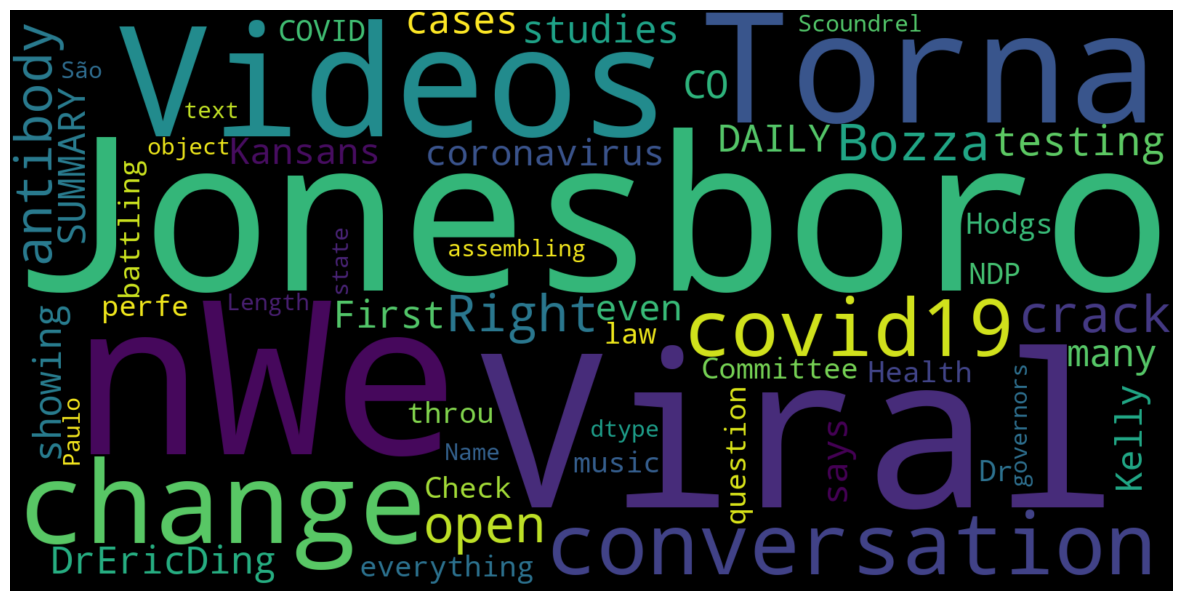

In [15]:
def show_wordcloud(data , title = None):
    wordcloud = WordCloud(background_color='black',stopwords=stopwords, max_words=200, width = 1600 , height = 800, collocations=False).generate(str(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.title(title, size = 25)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

show_wordcloud(tweet['text'])

### Feature Extraction

In [16]:
# Extracting hashtags and accounts
stoptags = ['#covid19', '#covid_19', '#covid-19', '#covid', '#coronavirus', '#outgreak', '#virus', '#pandemic']

tweet['tags'] = tweet['text'].str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$|\.,)')
tweet['tags'] = tweet['tags'].apply(lambda word_list:list(map(lambda w: w.lower(), word_list))).apply(lambda word_list:list(filter(lambda w: w not in stoptags, word_list)))

tweet['accts'] = tweet['text'].str.findall(r'(?:(?<=\s)|(?<=^))@.*?(?=\s|$)')
tweet['entity_text'] = tweet['tags'].apply(' '.join) + ' ' + tweet['accts'].apply(' '.join)
tweet.head()

,created_at,text,favourites_count,retweet_count,tags,accts,entity_text
0,2020-03-29T00:00:29Z,Jonesboro\nWe Get More Viral Videos Of A Torna...,8534,9,"[#newyork, #coronavirusoutbreak!]",[@Realpersonpltcs],#newyork #coronavirusoutbreak! @Realpersonpltcs
1,2020-03-29T00:00:42Z,In a change of conversation from #covid19 here...,6984,0,"[#cavalierkingcharles, #daftdug, #ladyandthetr...",[@disneyplus],#cavalierkingcharles #daftdug #ladyandthetramp...
2,2020-03-29T00:01:00Z,Right Bozza crack open them antibody testing k...,28,0,[#covid_19.],[],#covid_19.
3,2020-03-29T00:01:11Z,@DrEricDing There are many studies showing #CO...,22061,0,[],[@DrEricDing],@DrEricDing
4,2020-03-29T00:01:30Z,DAILY SUMMARY: First cases of #coronavirus in ...,79,1,[#coronavirusoutbreak],[@JHUSystems:],#coronavirusoutbreak @JHUSystems:


### Data Processing: Tokenizing and Removing Special Characters

In [17]:
# Tokenizing and Removing special charactors
for i in range(tweet.shape[0]) :
    tweet['text'][i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ", tweet['text'][i]).split()).lower()
tweet['text'].head()

0    jonesboro we get more viral videos of a tornad...
1    in a change of conversation from covid19 here ...
2    right bozza crack open them antibody testing k...
3    there are many studies showing covid19 can als...
4    daily summary first cases of coronavirus in ms...
Name: text, dtype: object

In [18]:
#Removing Stop Words
stopwords

tweet['text'] = tweet['text'].apply(lambda tweets: ' '.join([word for word in tweets.split() if word not in stopwords]))
tweet['text'].head() 

0    jonesboro viral videos tornado 15 minutes over...
1    change conversation covid19 charlie watching t...
2    right bozza crack open antibody testing kits l...
3    many studies showing covid19 airborne well dro...
4    daily summary first cases coronavirus ms zaand...
Name: text, dtype: object

### Tokenization

In [19]:
from gensim.utils import simple_preprocess

# Tokenize the text column to get the new column 'tokenized_text'
tweet['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in tweet['text']] 
print(tweet['tokenized_text'].head(10))

0    [jonesboro, viral, videos, tornado, minutes, o...
1    [change, conversation, covid, charlie, watchin...
2    [right, bozza, crack, open, antibody, testing,...
3    [many, studies, showing, covid, airborne, well...
4    [daily, summary, first, cases, coronavirus, ms...
5    [grandaughter, ft, us, granny, amp, poppy, day...
6    [well, new, twist, open, borders, quite, enter...
7    [drfauci, billgates, want, see, guys, together...
8    [workers, comp, coronavirus, part, workers, co...
9    [afraid, coronavirus, cases, will, reach, may,...
Name: tokenized_text, dtype: object


### Stemming

In [20]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()

# Get the stemmed_tokens
tweet['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in tweet['tokenized_text'] ]
tweet['stemmed_tokens'].head(10)

0    [jonesboro, viral, video, tornado, minut, over...
1    [chang, convers, covid, charli, watch, tonight...
2    [right, bozza, crack, open, antibodi, test, ki...
3    [mani, studi, show, covid, airborn, well, drop...
4    [daili, summari, first, case, coronaviru, ms, ...
5    [grandaught, ft, us, granni, amp, poppi, dai, ...
6    [well, new, twist, open, border, quit, enterta...
7    [drfauci, billgat, want, see, gui, togeth, wei...
8    [worker, comp, coronaviru, part, worker, compe...
9    [afraid, coronaviru, case, will, reach, mai, y...
Name: stemmed_tokens, dtype: object

## Step 4: Analyzing Text for Sentiment
#### We are using Textblob and Vader to analyze tweets to predict text sentiment and categorize as 'Positive', 'Negative' or 'Neutral'.

## 1. Using TextBlob

### 1.1 Finding Sentiments and Polarity

In [21]:
%time
tweet['sentiment'] = ' '
tweet['polarity'] = None
for i,tweets in enumerate(tweet.text) :
    blob = TextBlob(tweets)
    tweet['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        tweet['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        tweet['sentiment'][i] = 'negative'
    else :
        tweet['sentiment'][i] = 'neutral'
pd.set_option('display.max_colwidth', 400)
tweet.head()

Wall time: 0 ns


,created_at,text,favourites_count,retweet_count,tags,accts,entity_text,tokenized_text,stemmed_tokens,sentiment,polarity
0,2020-03-29T00:00:29Z,jonesboro viral videos tornado 15 minutes overflow hospitals newyork around world due coronavirusoutbreak ask,8534,9,"[#newyork, #coronavirusoutbreak!]",[@Realpersonpltcs],#newyork #coronavirusoutbreak! @Realpersonpltcs,"[jonesboro, viral, videos, tornado, minutes, overflow, hospitals, newyork, around, world, due, ask]","[jonesboro, viral, video, tornado, minut, overflow, hospit, newyork, around, world, due, ask]",negative,-0.125
1,2020-03-29T00:00:42Z,change conversation covid19 charlie watching tonight first time wondering lady went cavalierkingcharles daftdug ladyandthetramp,6984,0,"[#cavalierkingcharles, #daftdug, #ladyandthetramp]",[@disneyplus],#cavalierkingcharles #daftdug #ladyandthetramp @disneyplus,"[change, conversation, covid, charlie, watching, tonight, first, time, wondering, lady, went, daftdug, ladyandthetramp]","[chang, convers, covid, charli, watch, tonight, first, time, wonder, ladi, went, daftdug, ladyandthetramp]",positive,0.25
2,2020-03-29T00:01:00Z,right bozza crack open antibody testing kits lets see many us already recovered covid 19 hopefully put better perspective mortality rate,28,0,[#covid_19.],[],#covid_19.,"[right, bozza, crack, open, antibody, testing, kits, lets, see, many, us, already, recovered, covid, hopefully, put, better, perspective, mortality, rate]","[right, bozza, crack, open, antibodi, test, kit, let, see, mani, us, alreadi, recov, covid, hopefulli, put, better, perspect, mortal, rate]",positive,0.321429
3,2020-03-29T00:01:11Z,many studies showing covid19 airborne well droplet,22061,0,[],[@DrEricDing],@DrEricDing,"[many, studies, showing, covid, airborne, well, droplet]","[mani, studi, show, covid, airborn, well, droplet]",positive,0.5
4,2020-03-29T00:01:30Z,daily summary first cases coronavirus ms zaandam 2 coronavirusoutbreak covid19 full report,79,1,[#coronavirusoutbreak],[@JHUSystems:],#coronavirusoutbreak @JHUSystems:,"[daily, summary, first, cases, coronavirus, ms, zaandam, covid, full, report]","[daili, summari, first, case, coronaviru, ms, zaandam, covid, full, report]",positive,0.2


positive    74784
neutral     55942
negative    31674
Name: sentiment, dtype: int64


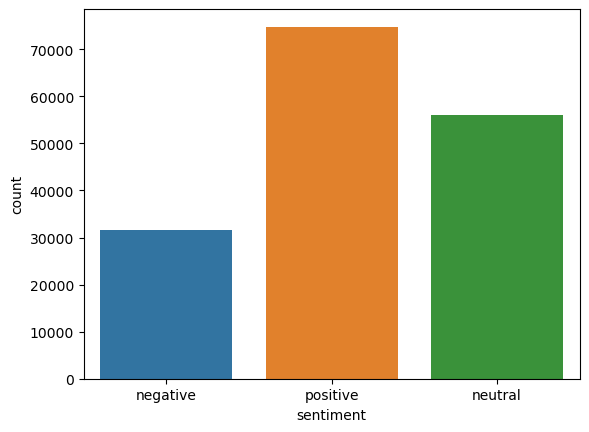

In [22]:
print(tweet.sentiment.value_counts())
sns.countplot(x='sentiment', data = tweet);

### 1.2 Expore favorite and retweet counts
A quick look at these showed that they are mostly inline with tweet count. So, we will just use tweet count for our study.

In [23]:
count = pd.DataFrame(tweet.groupby('sentiment')['favourites_count'].sum())
count.head()

,favourites_count
sentiment,
negative,491647134
neutral,712209451
positive,896452379


In [24]:
count = pd.DataFrame(tweet.groupby('sentiment')['retweet_count'].sum())
count.head()

,retweet_count
sentiment,
negative,200519
neutral,137032
positive,259451


### 1.3 Sentiment Distribution

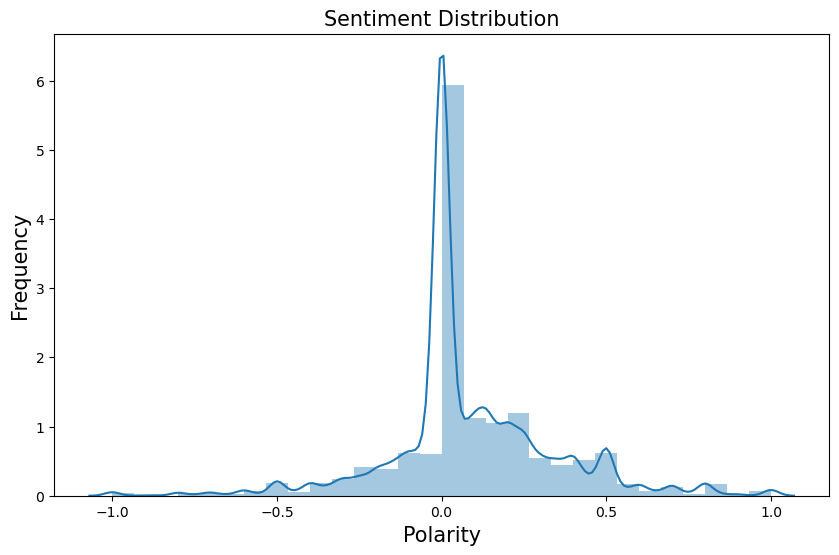

In [25]:
plt.figure(figsize=(10,6))
sns.distplot(tweet['polarity'], bins=30)
plt.title('Sentiment Distribution',size = 15)
plt.xlabel('Polarity',size = 15)
plt.ylabel('Frequency',size = 15)
plt.show();

### 1.4 Sentiment Over Time

In [26]:
# format timestamp
tweet['created_at'] = pd.to_datetime(tweet['created_at'])
tweet['created_at'] = pd.IntervalIndex(pd.cut(tweet['created_at'], pd.date_range('2020-03-29', '2020-05-01', freq='2880T'))).left

# count sentiment
tweet_count1 = tweet.groupby(['created_at','sentiment'])['text'].count().reset_index().rename(columns={'text':'count'})
tweet_count1.head()

,created_at,sentiment,count
0,2020-03-29 00:00:00+00:00,negative,2467
1,2020-03-29 00:00:00+00:00,neutral,4605
2,2020-03-29 00:00:00+00:00,positive,5406
3,2020-03-31 00:00:00+00:00,negative,2866
4,2020-03-31 00:00:00+00:00,neutral,4952


<function matplotlib.pyplot.show(close=None, block=None)>

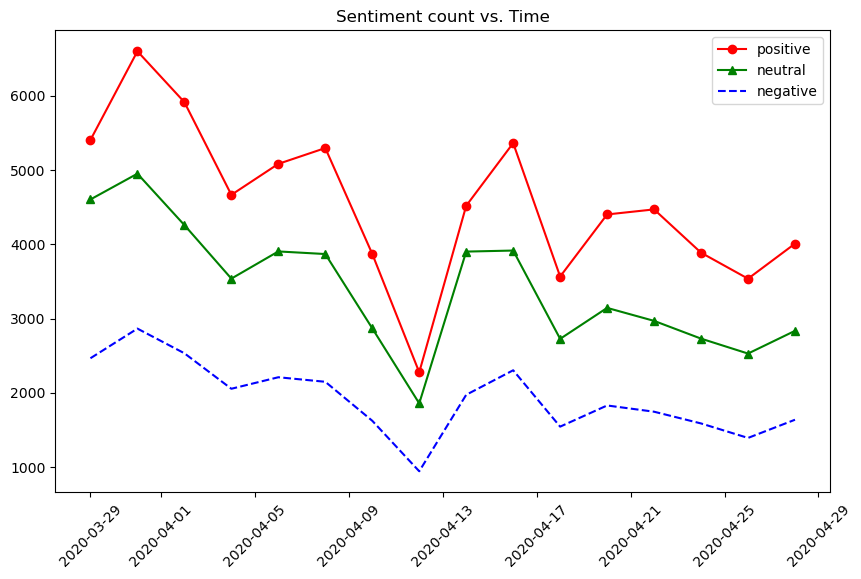

In [27]:
#format sentiment table
times = tweet_count1.loc[tweet_count1['sentiment'] == 'negative']['created_at'].reset_index(drop = True)
pos = tweet_count1.loc[tweet_count1['sentiment'] == 'positive']['count'].reset_index(drop = True)
neutral = tweet_count1.loc[tweet_count1['sentiment'] == 'neutral']['count'].reset_index(drop = True)
neg = tweet_count1.loc[tweet_count1['sentiment'] == 'negative']['count'].reset_index(drop = True)

plt.figure(figsize=(10,6))
plt.xticks(rotation='45')
plt.title("Sentiment count vs. Time")

lin1=plt.plot(times, pos, 'ro-', label='positive')
lin2=plt.plot(times, neutral, 'g^-', label='neutral')
lin3=plt.plot(times, neg, 'b--', label='negative')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

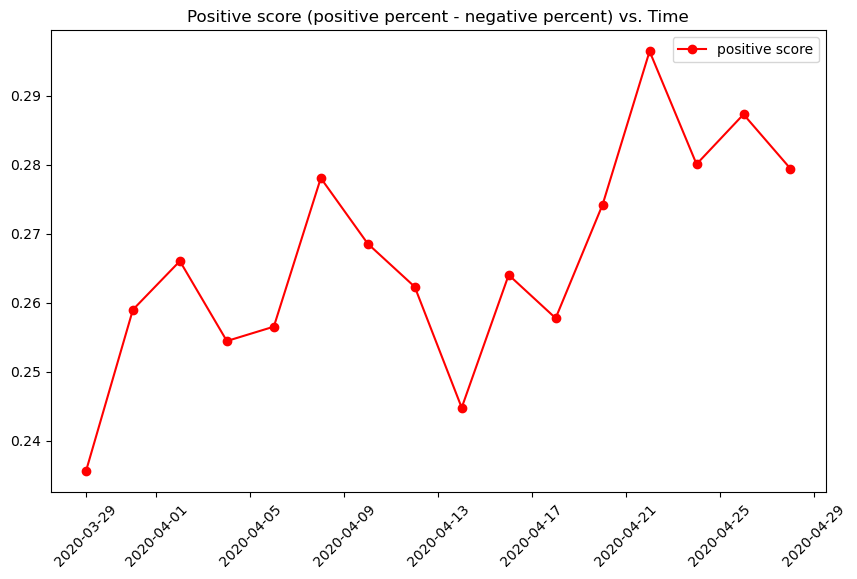

In [28]:
# "score" is defined as percent of positive tweets minus percent of negative tweets
score = (pos - neg) / (pos + neutral + neg)

plt.figure(figsize=(10,6))
plt.xticks(rotation='45')
plt.title("Positive score (positive percent - negative percent) vs. Time")

lin1=plt.plot(times, score, 'ro-', label='positive score')
plt.legend()
plt.show

### 1.5 Tags with the most Negative and Postive Sentiment

In [29]:
all_words = []
all_words = [word for i in tweet.entity_text for word in i.split()]
pos_words = tweet['entity_text'][tweet['sentiment'] == 'positive']
neg_words = tweet['entity_text'][tweet['sentiment'] == 'negative']
neutral_words = tweet['entity_text'][tweet['sentiment'] == 'neutral']

def get_freq(word_list):
    freq = Counter(word_list).most_common(100)
    freq = pd.DataFrame(freq)
    freq.columns = ['word', 'frequency']
    return freq

all_freq = get_freq(all_words)
pos_freq = get_freq([word for i in pos_words for word in i.split()])
neg_freq = get_freq([word for i in neg_words for word in i.split()])

freq = pd.merge(all_freq,pos_freq,on='word',how='left').rename(columns={'frequency_x':'total','frequency_y':'pos'})
freq = pd.merge(freq,neg_freq,on='word',how='left').rename(columns={'frequency':'neg'}).fillna(0)
freq['score'] = (freq['pos'] - freq['neg'] ) / freq['total']

neg_freq_filtered = freq[(freq['score'] < 0.2) & (freq['neg'] > 0)].head(40).sort_values('score',ascending = True)

neg_freq_filtered.head(40)

,word,total,pos,neg,score
91,@GOP,305,0.0,112.0,-0.367213
88,#fakenews,309,0.0,109.0,-0.352751
89,@MattHancock,308,0.0,92.0,-0.298701
82,@WhiteHouse,335,0.0,98.0,-0.292537
85,@SpeakerPelosi,328,0.0,94.0,-0.286585
97,#donaldtrump,280,0.0,80.0,-0.285714
87,#iran,319,0.0,81.0,-0.253918
90,#chinesevirus,305,0.0,73.0,-0.239344
71,#wuhan,370,0.0,83.0,-0.224324
92,#wuhanvirus,304,0.0,63.0,-0.207237


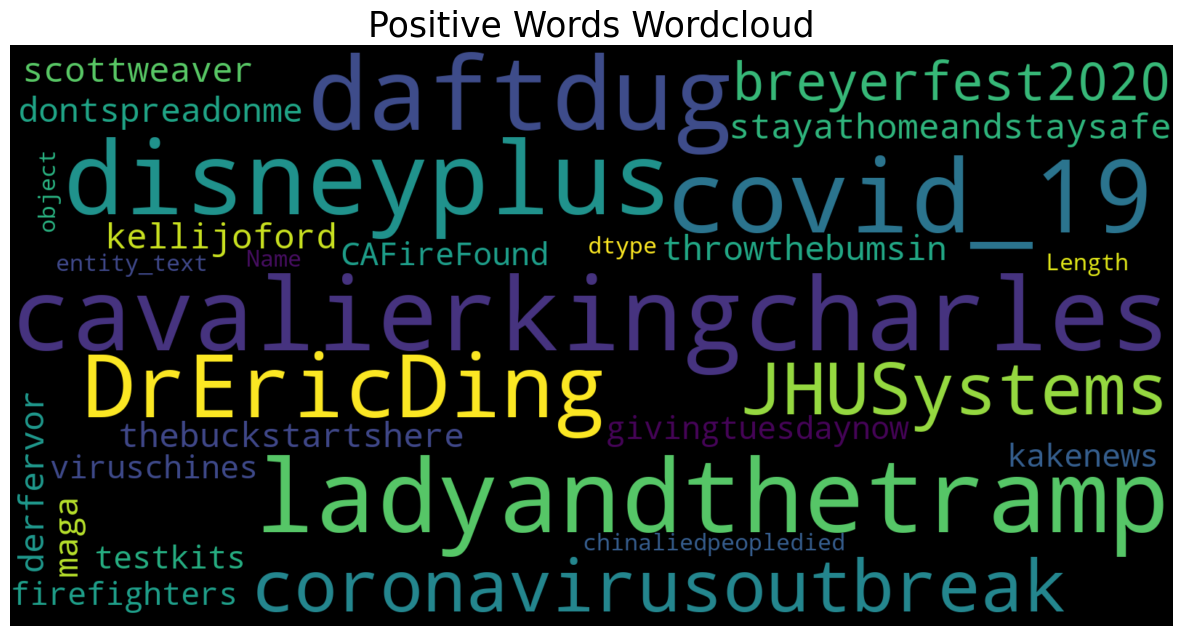

In [30]:
show_wordcloud(pos_words , 'Positive Words Wordcloud')

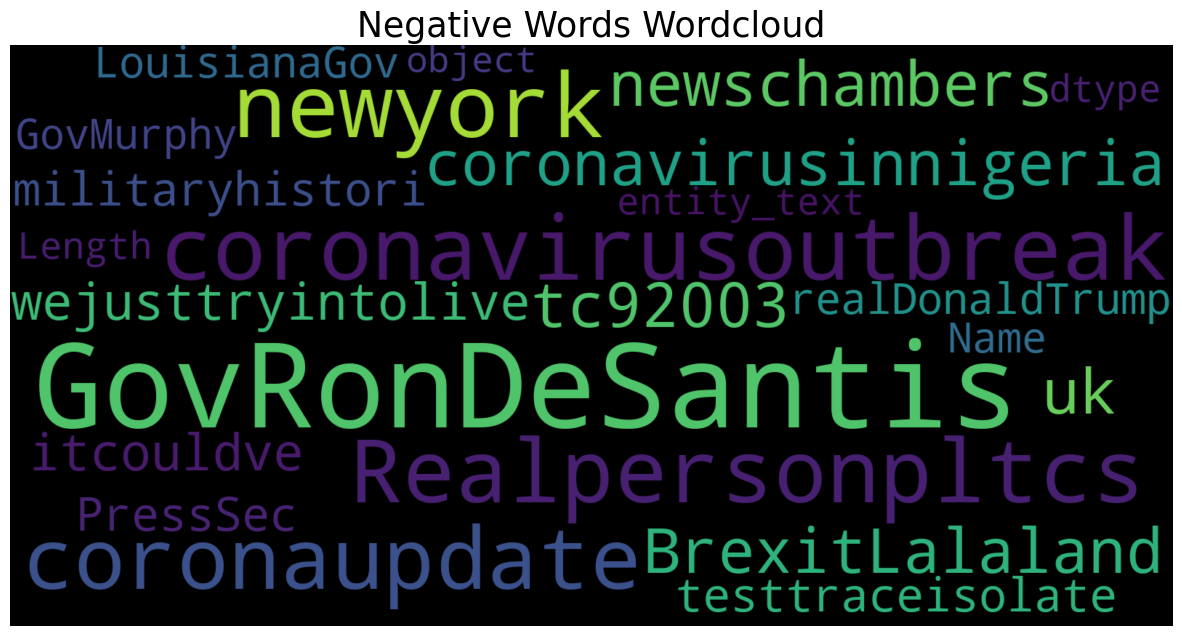

In [31]:
show_wordcloud(neg_words , 'Negative Words Wordcloud')

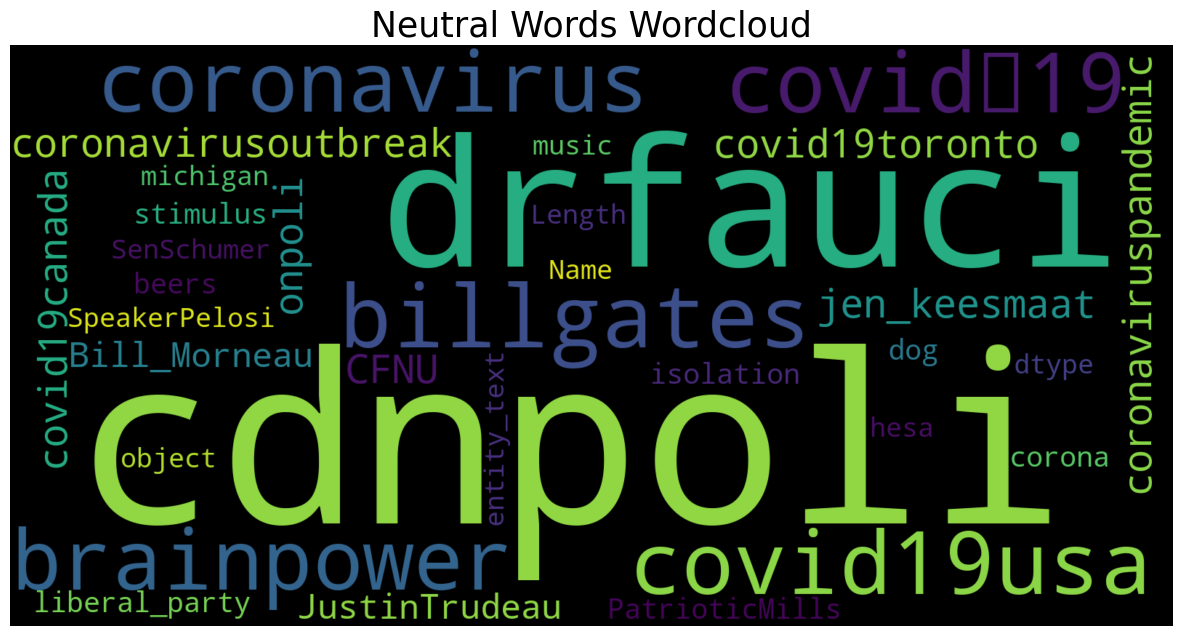

In [32]:
show_wordcloud(neutral_words , 'Neutral Words Wordcloud')

In [33]:
#Positive 
freq[(freq['score'] >0.4) & (freq['pos'] !=0)].head(40).sort_values('score',ascending = False)

,word,total,pos,neg,score
99,#love,273,267.0,0.0,0.978022
95,#inthistogether,296,168.0,0.0,0.567568
96,#isolation,290,161.0,0.0,0.555172
69,#workfromhome,377,203.0,0.0,0.538462
78,#washyourhands,348,169.0,0.0,0.485632
65,#covid19india,395,182.0,0.0,0.460759
74,#vaccine,358,163.0,0.0,0.455307
61,#business,416,185.0,0.0,0.444712
30,#stayathomeandstaysafe,775,433.0,94.0,0.437419
68,#italy,378,165.0,0.0,0.436508


### 1.6 Plotting Barplot

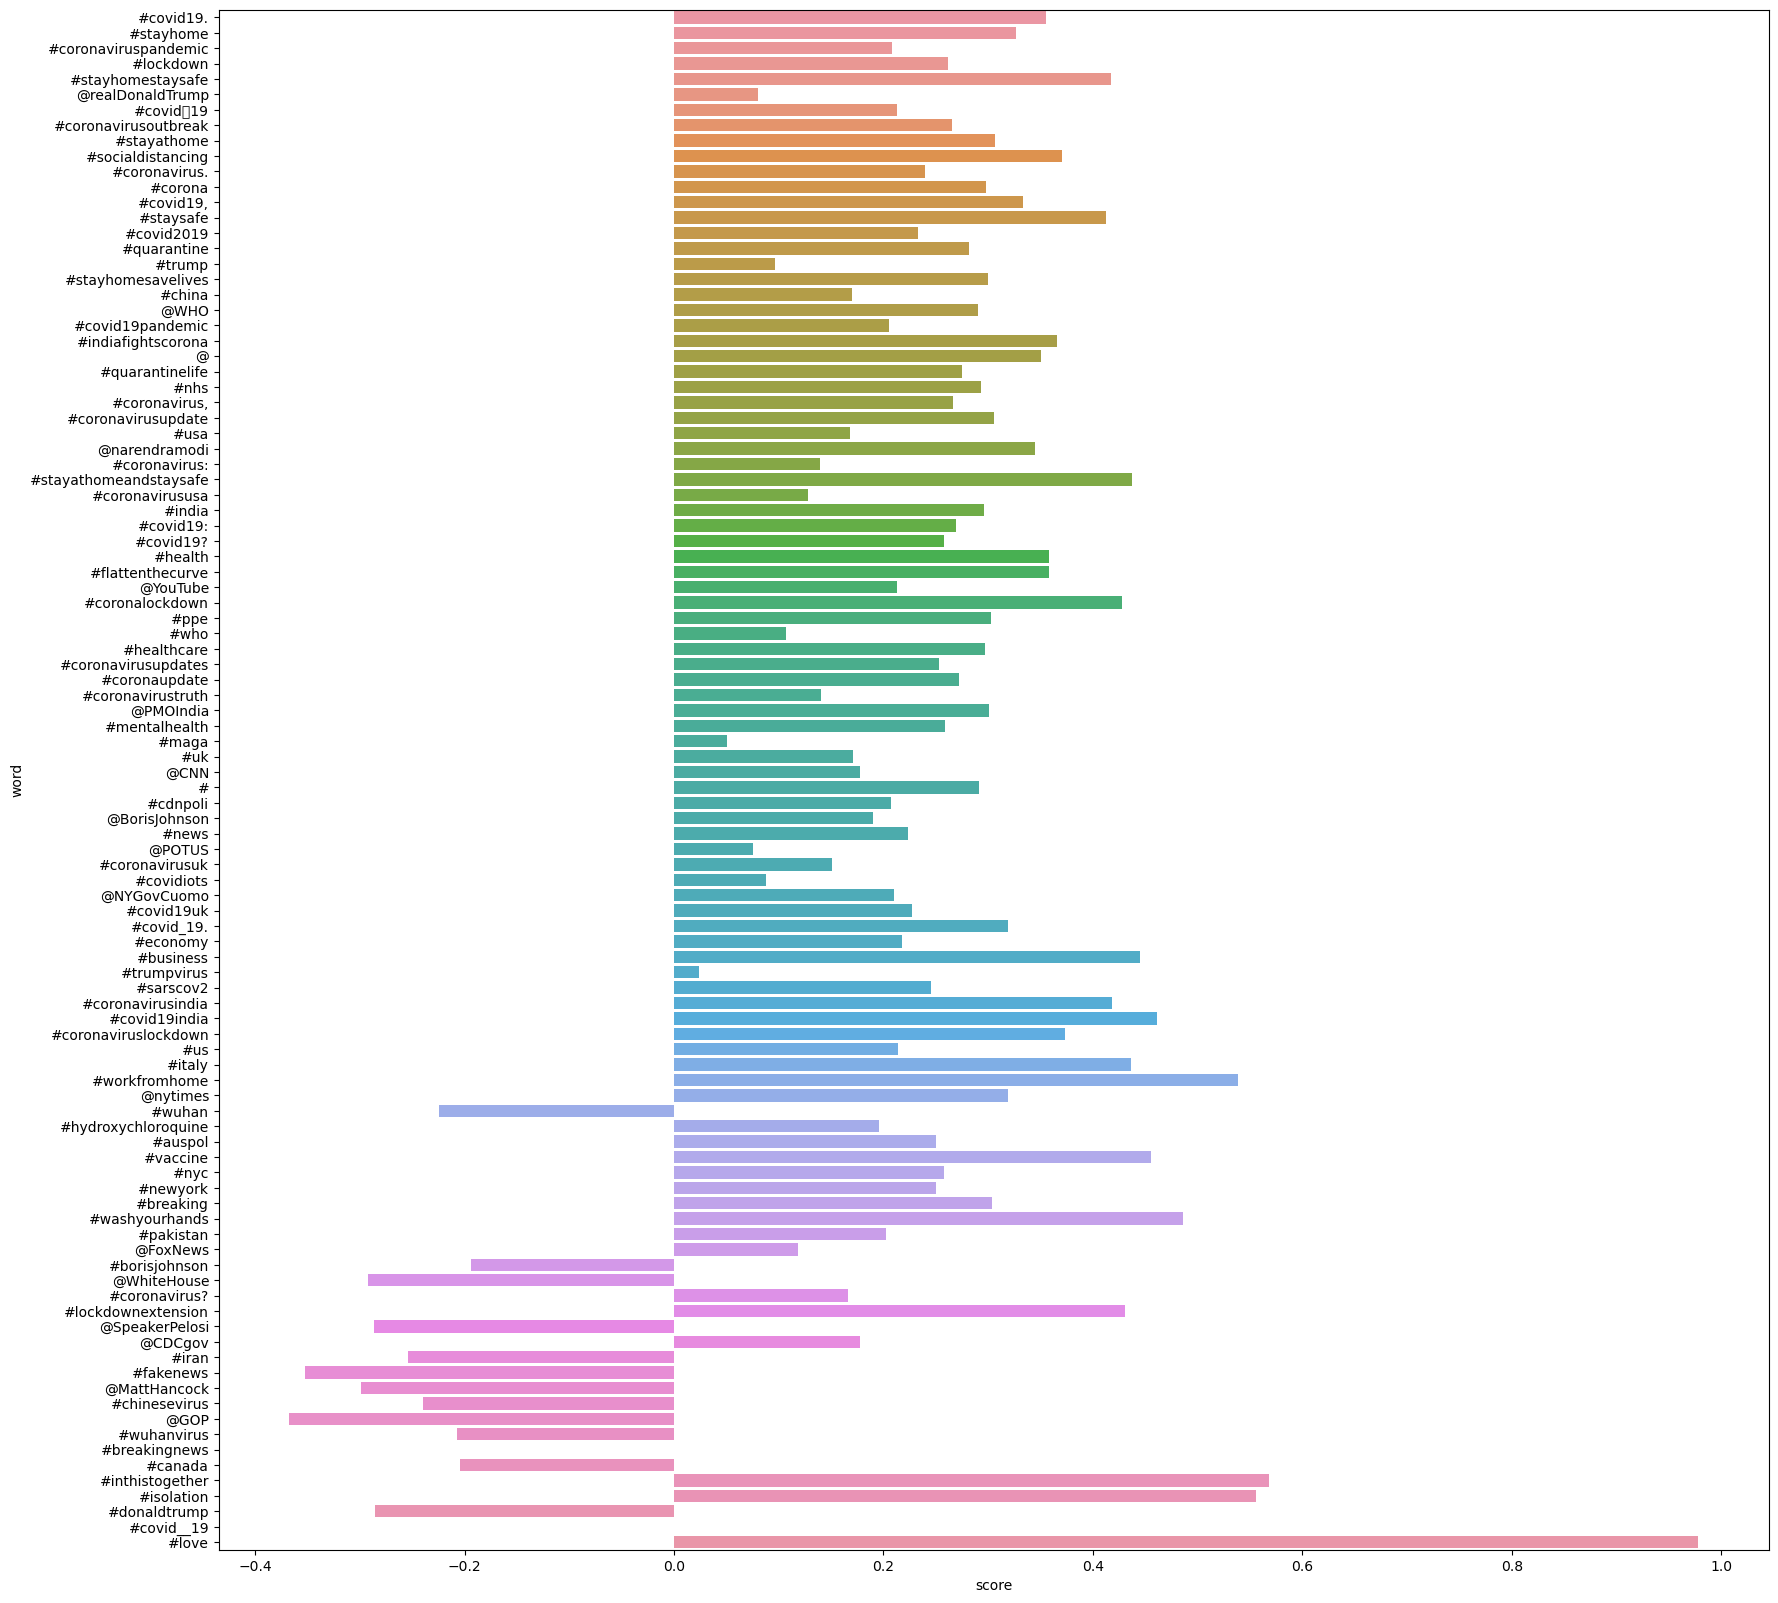

In [34]:
plt.figure(figsize = (20, 20))
sns.barplot(y="word", x="score",data=freq);

## 2. Vader Analysis
<ul>
    <li>Vader is a lexicon-based sentiment analysis tool that works with social media data.</li>
    <li>It uses a combination of dictionary lookup and rule-based techniques to identify the sentiment of a piece of text and can effectively handle slang, emoticons, and other informal languages commonly used on social media.</li>
    <li>Vader is implemented in Python and is available as a package in the Natural Language Toolkit (NLTK).</li>
    <li>It is a fast and easy-to-use tool for performing sentiment analysis on various text data, including social media posts, customer reviews, and more.</li>
    <li>It is important to note that, like any automated tool, Vader may only sometimes provide accurate results and should be used as one component of a more extensive sentiment analysis system. Human review and interpretation may be necessary to ensure the accuracy of the results.</li>
</ul>

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()


def format_output(output_dict):
    
    polarity = "neutral"
    
    if(output_dict['compound']>= 0.05):
        polarity = "positive"

    elif(output_dict['compound']<= -0.05):
        polarity = "negative"

    return polarity

def predict_sentiment(text):
  
    output_dict =  sent_analyzer.polarity_scores(text)
    return format_output(output_dict)

def predict_polarity(text):
  
    return sent_analyzer.polarity_scores(text)['compound']

# Run the predictions
tweet["vader_prediction"] = tweet["text"].apply(predict_sentiment)
tweet["vader_prediction_polarity"] = tweet["text"].apply(predict_polarity)

# Show 5 random rows of the data
tweet.sample(5)

,created_at,text,favourites_count,retweet_count,tags,accts,entity_text,tokenized_text,stemmed_tokens,sentiment,polarity,vader_prediction,vader_prediction_polarity
154478,2020-04-28 00:00:00+00:00,everyday heroes salute front line people working everyday keep us safe secured amazed courage dedication truly heroes police hero jharkhandpolice ranchipolice indianpolice lockdown2020 stayhomestaysafe,69,0,"[#police, #hero, #jharkhandpolice, #ranchipolice, #indianpolice, #lockdown2020, #stayhomestaysafe]",[],#police #hero #jharkhandpolice #ranchipolice #indianpolice #lockdown2020 #stayhomestaysafe,"[everyday, heroes, salute, front, line, people, working, everyday, keep, us, safe, secured, amazed, courage, dedication, truly, heroes, police, hero, jharkhandpolice, ranchipolice, indianpolice, lockdown]","[everydai, hero, salut, front, line, peopl, work, everydai, keep, us, safe, secur, amaz, courag, dedic, truli, hero, polic, hero, jharkhandpolic, ranchipolic, indianpolic, lockdown]",positive,0.033333,positive,0.9753
37246,2020-04-02 00:00:00+00:00,sdybooks reader looking right books informative entertaining got covered b9a fdark wla tjina khbarek covid19 coronavirus stayhome weact4sdgs,297,1,"[#sdybooks, #بقا_فدارك_ولاتجينا_خبارك, #b9a_fdark_wla_tjina_khbarek, #stayhome, #weact4sdgs]",[],#sdybooks #بقا_فدارك_ولاتجينا_خبارك #b9a_fdark_wla_tjina_khbarek #stayhome #weact4sdgs,"[sdybooks, reader, looking, right, books, informative, entertaining, got, covered, fdark, wla, tjina, khbarek, covid, coronavirus, stayhome, weact, sdgs]","[sdybook, reader, look, right, book, inform, entertain, got, cover, fdark, wla, tjina, khbarek, covid, coronaviru, stayhom, weact, sdg]",positive,0.392857,positive,0.4404
24864,2020-03-31 00:00:00+00:00,covid19 cases involving health care sector workers linked travel russell adds makes sense,977,0,[],[],,"[covid, cases, involving, health, care, sector, workers, linked, travel, russell, adds, makes, sense]","[covid, case, involv, health, care, sector, worker, link, travel, russel, add, make, sens]",neutral,0.0,positive,0.4939
87247,2020-04-14 00:00:00+00:00,usa italy spain france uk covid 19,33321,0,[],[],,"[usa, italy, spain, france, uk, covid]","[usa, itali, spain, franc, uk, covid]",neutral,0.0,neutral,0.0000
50140,2020-04-06 00:00:00+00:00,found display elevator now know dogs excited go walks covid 19,306,0,[],[],,"[found, display, elevator, now, know, dogs, excited, go, walks, covid]","[found, displai, elev, now, know, dog, excit, go, walk, covid]",positive,0.375,positive,0.3400


positive    74560
negative    50486
neutral     37354
Name: vader_prediction, dtype: int64


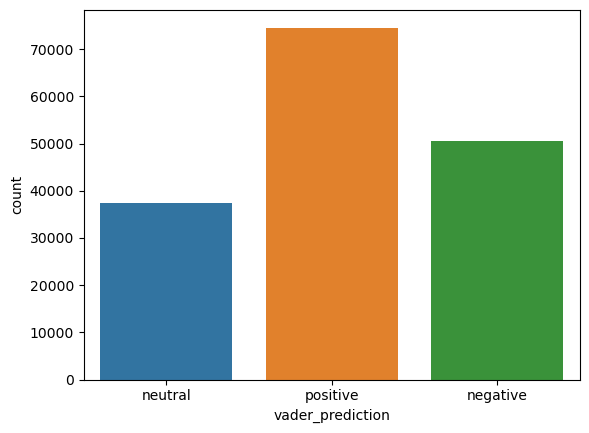

In [36]:
print(tweet.vader_prediction.value_counts())
sns.countplot(x='vader_prediction', data = tweet);

### 2.2 Expore favorite and retweet counts
A quick look at these showed that they are mostly inline with tweet count. So, we will just use tweet count for our study.

In [37]:
count = pd.DataFrame(tweet.groupby('vader_prediction')['favourites_count'].sum())
count.head()

,favourites_count
vader_prediction,
negative,790649854
neutral,465595267
positive,844063843


In [38]:
count = pd.DataFrame(tweet.groupby('vader_prediction')['retweet_count'].sum())
count.head()

,retweet_count
vader_prediction,
negative,234829
neutral,102026
positive,260147


### 2.3 Sentiment Distribution

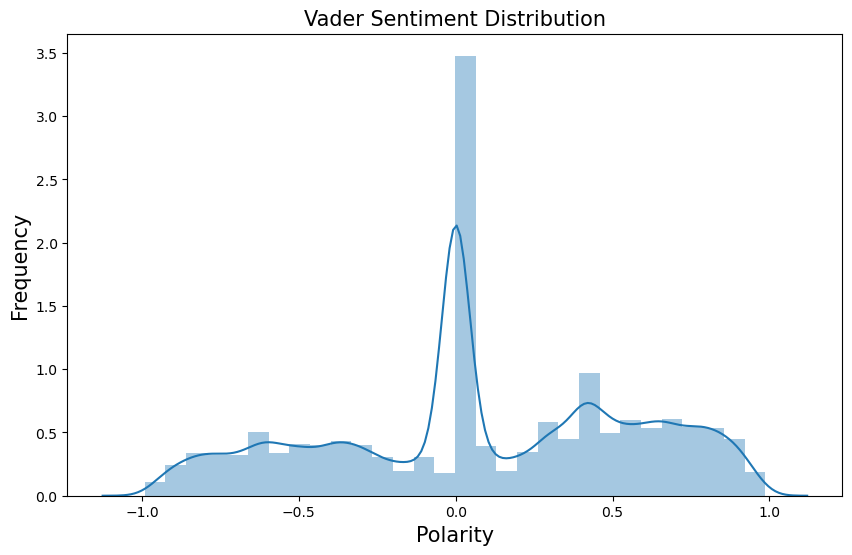

In [39]:
plt.figure(figsize=(10,6))
sns.distplot(tweet['vader_prediction_polarity'], bins=30)
plt.title('Vader Sentiment Distribution',size = 15)
plt.xlabel('Polarity',size = 15)
plt.ylabel('Frequency',size = 15)
plt.show();

### 2.4 Sentiment Over Time

In [40]:
# format timestamp
tweet['created_at'] = pd.to_datetime(tweet['created_at'])
tweet['created_at'] = pd.IntervalIndex(pd.cut(tweet['created_at'], pd.date_range('2020-03-29', '2020-05-01', freq='2880T'))).left

# count sentiment
tweet_count1 = tweet.groupby(['created_at','vader_prediction'])['text'].count().reset_index().rename(columns={'text':'count'})
tweet_count1.head()

,created_at,vader_prediction,count
0,2020-03-29 00:00:00+00:00,negative,4673
1,2020-03-29 00:00:00+00:00,neutral,3271
2,2020-03-29 00:00:00+00:00,positive,6474
3,2020-03-31 00:00:00+00:00,negative,4195
4,2020-03-31 00:00:00+00:00,neutral,2947


<function matplotlib.pyplot.show(close=None, block=None)>

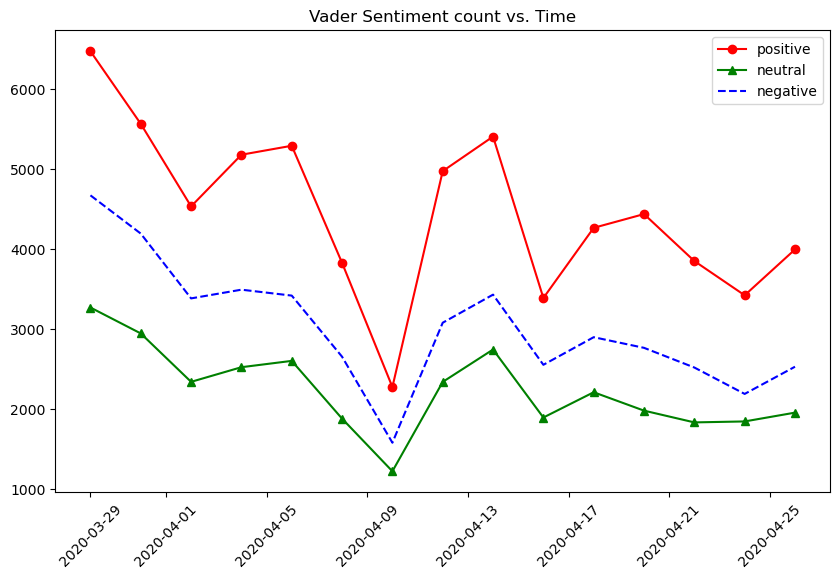

In [41]:
#format sentiment table
times = tweet_count1.loc[tweet_count1['vader_prediction'] == 'negative']['created_at'].reset_index(drop = True)
pos = tweet_count1.loc[tweet_count1['vader_prediction'] == 'positive']['count'].reset_index(drop = True)
neutral = tweet_count1.loc[tweet_count1['vader_prediction'] == 'neutral']['count'].reset_index(drop = True)
neg = tweet_count1.loc[tweet_count1['vader_prediction'] == 'negative']['count'].reset_index(drop = True)

plt.figure(figsize=(10,6))
plt.xticks(rotation='45')
plt.title("Vader Sentiment count vs. Time")

lin1=plt.plot(times, pos, 'ro-', label='positive')
lin2=plt.plot(times, neutral, 'g^-', label='neutral')
lin3=plt.plot(times, neg, 'b--', label='negative')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

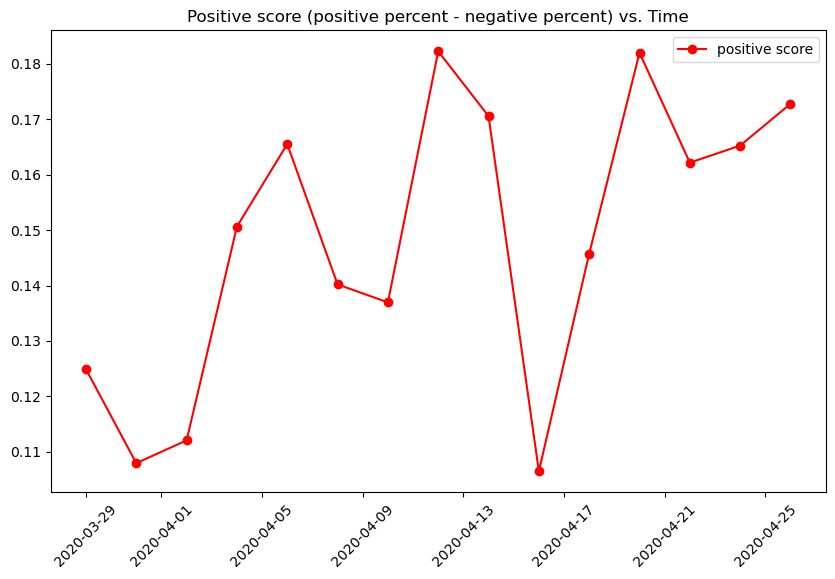

In [42]:
# "score" is defined as percent of positive tweets minus percent of negative tweets
score = (pos - neg) / (pos + neutral + neg)

plt.figure(figsize=(10,6))
plt.xticks(rotation='45')
plt.title("Positive score (positive percent - negative percent) vs. Time")

lin1=plt.plot(times, score, 'ro-', label='positive score')
plt.legend()
plt.show

### 2.5 Tags with the most Negative and Postive Sentiment

In [43]:
all_words = []
all_words = [word for i in tweet.entity_text for word in i.split()]
pos_words = tweet['entity_text'][tweet['vader_prediction'] == 'positive']
neg_words = tweet['entity_text'][tweet['vader_prediction'] == 'negative']
neutral_words = tweet['entity_text'][tweet['vader_prediction'] == 'neutral']

def get_freq(word_list):
    freq = Counter(word_list).most_common(100)
    freq = pd.DataFrame(freq)
    freq.columns = ['word', 'frequency']
    return freq

all_freq = get_freq(all_words)
pos_freq = get_freq([word for i in pos_words for word in i.split()])
neg_freq = get_freq([word for i in neg_words for word in i.split()])

freq = pd.merge(all_freq,pos_freq,on='word',how='left').rename(columns={'frequency_x':'total','frequency_y':'pos'})
freq = pd.merge(freq,neg_freq,on='word',how='left').rename(columns={'frequency':'neg'}).fillna(0)
freq['score'] = (freq['pos'] - freq['neg'] ) / freq['total']

neg_freq_filtered = freq[(freq['score'] < 0.2) & (freq['neg'] > 0)].head(40).sort_values('score',ascending = True)

neg_freq_filtered.head(40)

,word,total,pos,neg,score
62,#trumpvirus,413,0.0,215.0,-0.520581
16,#trump,1720,520.0,859.0,-0.197093
5,@realDonaldTrump,3583,1199.0,1832.0,-0.176668
18,#china,1327,404.0,617.0,-0.160512
49,@CNN,564,186.0,258.0,-0.127660
54,@POTUS,518,189.0,255.0,-0.127413
47,#maga,590,202.0,277.0,-0.127119
56,#covidiots,488,162.0,220.0,-0.118852
60,#economy,432,137.0,180.0,-0.099537
40,#who,674,223.0,279.0,-0.083086


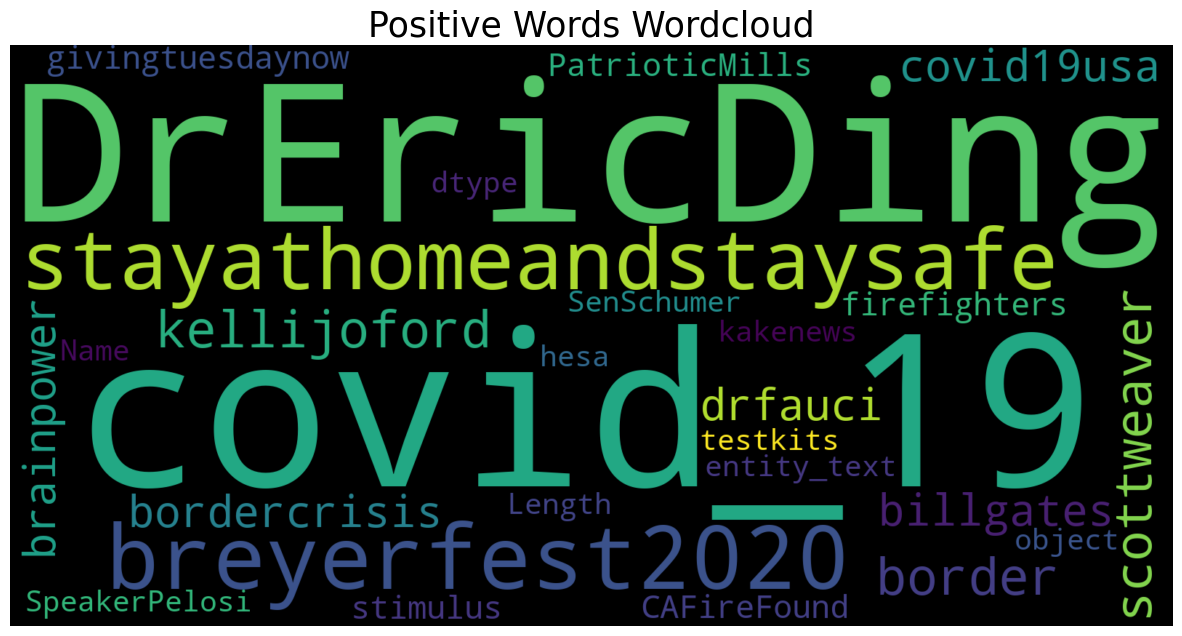

In [44]:
show_wordcloud(pos_words , 'Positive Words Wordcloud')

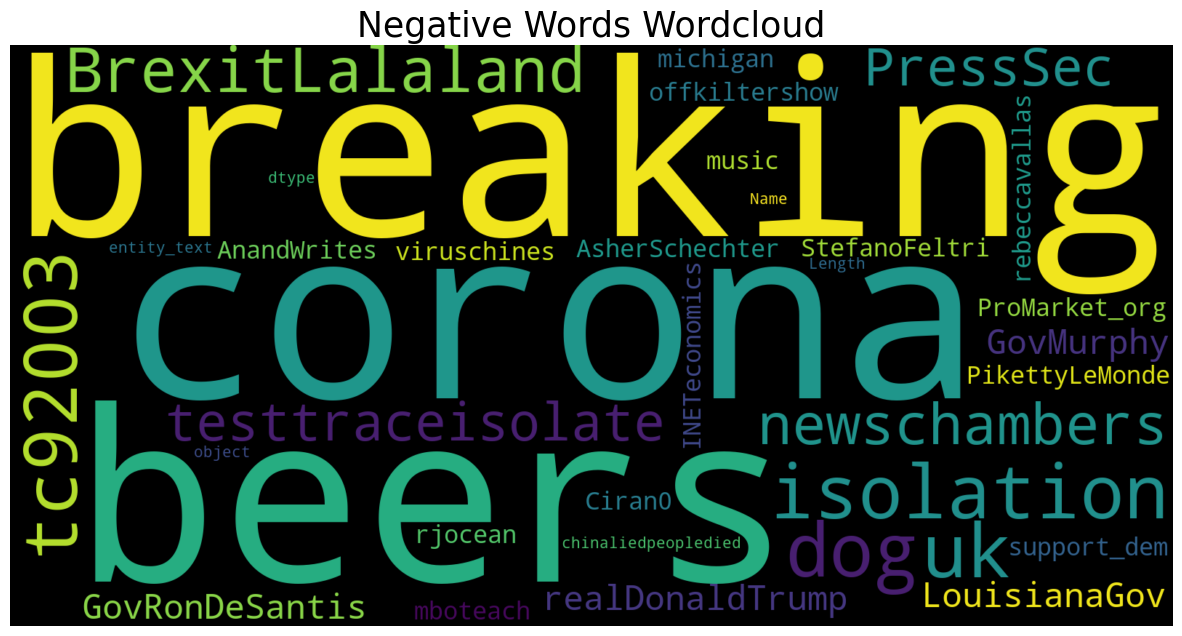

In [45]:
show_wordcloud(neg_words , 'Negative Words Wordcloud')

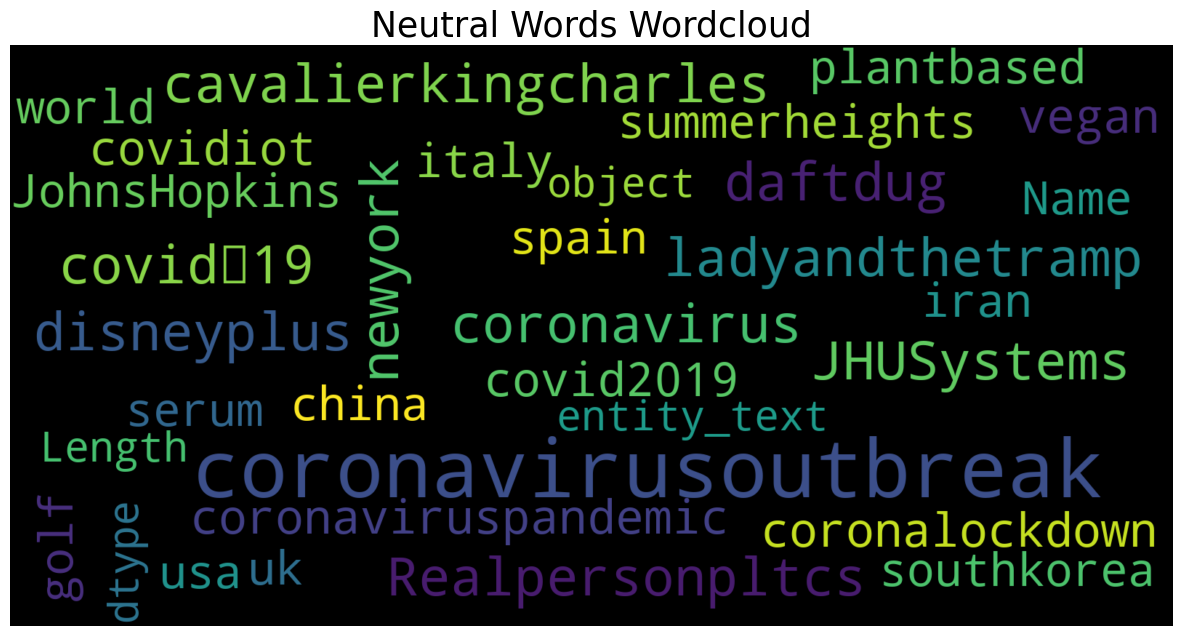

In [46]:
show_wordcloud(neutral_words , 'Neutral Words Wordcloud')

In [47]:
#Positive 
freq[(freq['score'] >0.4) & (freq['pos'] !=0)].head(40).sort_values('score',ascending = False)

,word,total,pos,neg,score
99,#love,273,265.0,0.0,0.970696
95,#inthistogether,296,202.0,0.0,0.682432
69,#workfromhome,377,213.0,0.0,0.564987
81,#borisjohnson,336,180.0,0.0,0.535714
78,#washyourhands,348,178.0,0.0,0.511494
4,#stayhomestaysafe,3695,2326.0,484.0,0.498512
84,#lockdownextension,332,164.0,0.0,0.493976
61,#business,416,205.0,0.0,0.492788
94,#canada,299,142.0,0.0,0.474916
30,#stayathomeandstaysafe,775,472.0,115.0,0.460645


### 2.6 Plotting Barplot

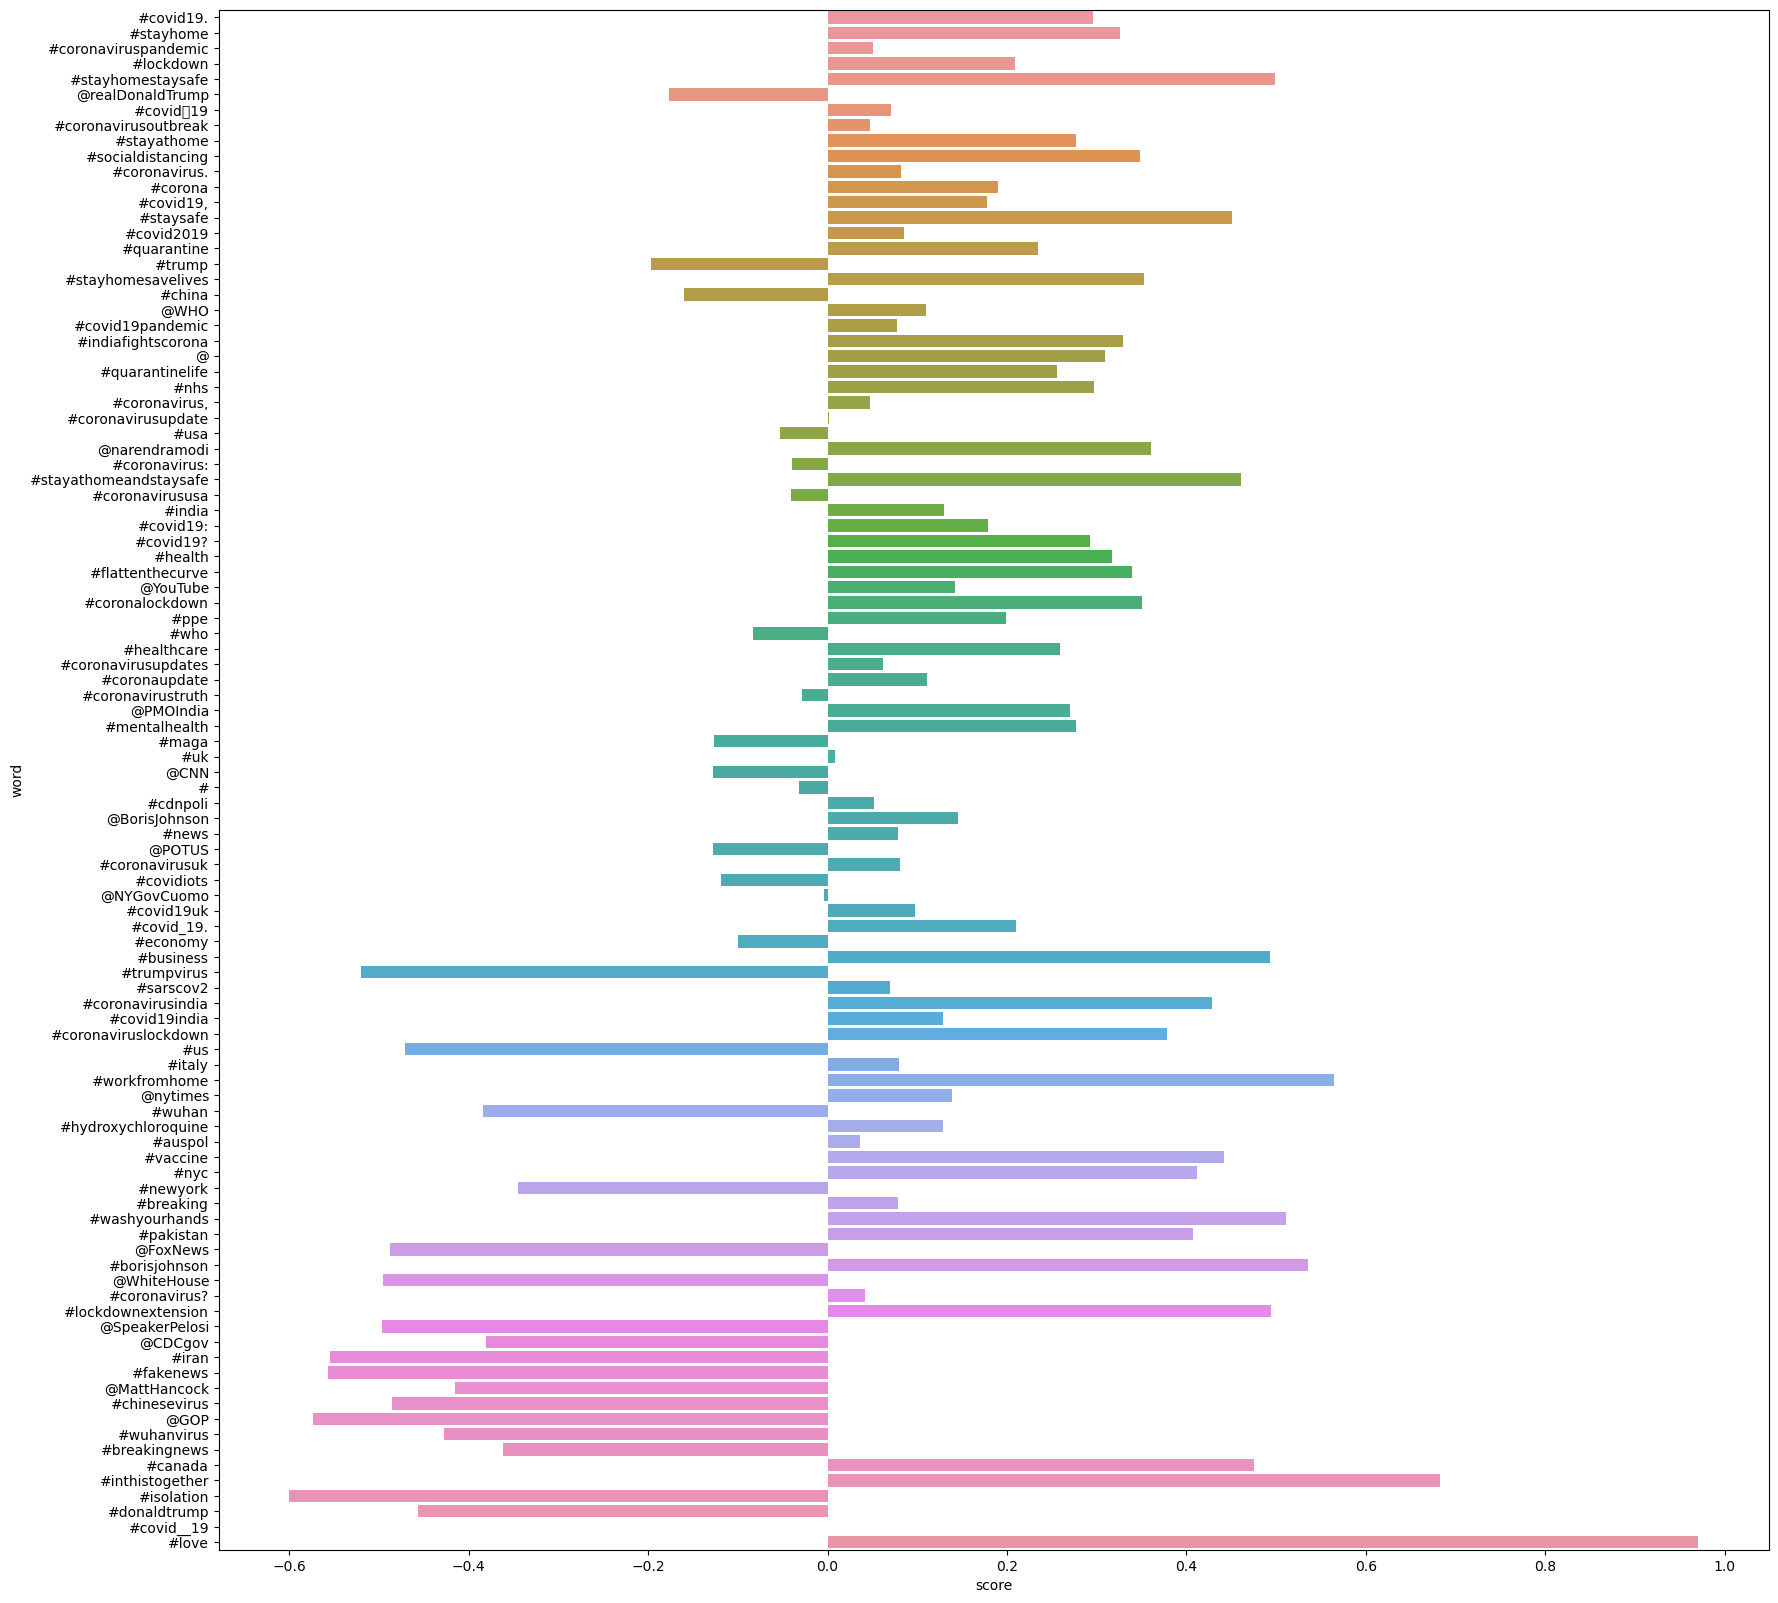

In [48]:
plt.figure(figsize = (20, 20))
sns.barplot(y="word", x="score",data=freq);

## Step-5: Using Word2Vec

<p>Word2Vec is a method for creating vector representations of words in a language, which can be used for various natural language processing tasks such as machine translation, document classification, and information retrieval. The idea behind Word2Vec is to use the context in which a word appears to infer its meaning.</p>
<p>The primary approach is to train a neural network on a large text corpus to predict the surrounding words given a central word. The hidden layer weights of the network are then used as the vector representation of the words, with the vectors for similar words being close together in vector space.</p>
<p>There are two main variants of Word2Vec: continuous bag-of-words (CBOW) and skip-gram. CBOW predicts the target word given the surrounding context, while skip-gram predicts the surrounding context given a target word. Skip-gram performs better for smaller datasets, while CBOW is faster to train.</p>
<p>Word2Vec has been widely used and has been shown to produce high-quality word vectors that capture the semantics of words and can capture relationships such as analogy and similarity. It has also been used as a basis for more advanced models such as GloVe and FastText.</p>

#### We are proceeding with the TextBlob Sentiment Analysis Results to work with Word2Vec 

In [49]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(tweet['sentiment'])
 
# printing label
label

array([0, 2, 2, ..., 1, 1, 2])

In [50]:
tweet["sentiment_numerical"] = label

In [51]:
tweet["sentiment_numerical"] = tweet["sentiment_numerical"].replace({2:1, 1:0, 0:-1})

In [52]:
tweet.sample(5)

,created_at,text,favourites_count,retweet_count,tags,accts,entity_text,tokenized_text,stemmed_tokens,sentiment,polarity,vader_prediction,vader_prediction_polarity,sentiment_numerical
62108,2020-04-06 00:00:00+00:00,one gets sense coronavirus will game changer world history s eerie sense among many s palpable life will never quite coronapocalypse,1,0,[#coronapocalypse],[],#coronapocalypse,"[one, gets, sense, coronavirus, will, game, changer, world, history, eerie, sense, among, many, palpable, life, will, never, quite, coronapocalypse]","[on, get, sens, coronaviru, will, game, changer, world, histori, eeri, sens, among, mani, palpabl, life, will, never, quit, coronapocalyps]",negative,-0.1,negative,-0.3612,-1
146941,2020-04-24 00:00:00+00:00,covid19 2009 75 million usaid funding went predict program ecohealth alliance february 2020 predict program suddenly shut shutdown predict infectious disease program challenged senators warren king,50163,1,[],[],,"[covid, million, usaid, funding, went, predict, program, ecohealth, alliance, february, predict, program, suddenly, shut, shutdown, predict, infectious, disease, program, challenged, senators, warren, king]","[covid, million, usaid, fund, went, predict, program, ecohealth, allianc, februari, predict, program, suddenli, shut, shutdown, predict, infecti, diseas, program, challeng, senat, warren, king]",neutral,0.0,negative,-0.1027,0
141698,2020-04-22 00:00:00+00:00,abstract macro background effervescing golden champagne bubbles gold background bacteria golden aqua microbiology covid 19 stayhome,13,1,"[#gold, #background, #bacteria, #golden, #aqua, #microbiology, #stayhome]",[],#gold #background #bacteria #golden #aqua #microbiology #stayhome,"[abstract, macro, background, effervescing, golden, champagne, bubbles, gold, background, bacteria, golden, aqua, microbiology, covid, stayhome]","[abstract, macro, background, effervesc, golden, champagn, bubbl, gold, background, bacteria, golden, aqua, microbiolog, covid, stayhom]",positive,0.3,positive,0.2960,1
59097,2020-04-04 00:00:00+00:00,new t shirt design search nesshead ll find shirt sale today nesshead covid19 coronavirus tshirtdesign graphicdesign art artist artiste artista atisuto cartoonist ratfink edroth artistic unity artistic,562,1,"[#nesshead, #tshirtdesign, #graphicdesign, #art, #artist, #artiste, #artista, #atisuto, #cartoonist, #ratfink, #edroth, #artistic_unity_, #artistic]",[],#nesshead #tshirtdesign #graphicdesign #art #artist #artiste #artista #atisuto #cartoonist #ratfink #edroth #artistic_unity_ #artistic,"[new, shirt, design, search, nesshead, ll, find, shirt, sale, today, nesshead, covid, coronavirus, tshirtdesign, graphicdesign, art, artist, artiste, artista, atisuto, cartoonist, ratfink, edroth, artistic, unity, artistic]","[new, shirt, design, search, nesshead, ll, find, shirt, sale, todai, nesshead, covid, coronaviru, tshirtdesign, graphicdesign, art, artist, artist, artista, atisuto, cartoonist, ratfink, edroth, artist, uniti, artist]",positive,0.267677,neutral,0.0000,1
132484,2020-04-20 00:00:00+00:00,covid19,3892,0,[],[],,[covid],[covid],neutral,0.0,neutral,0.0000,0


### Label Encoder endcoded the sentiment in the following manner:
<ul>
    <li>1 - Positive</li>
    <li>0 - Neutral</li>
    <li>-1 - Negative</li>
</ul>

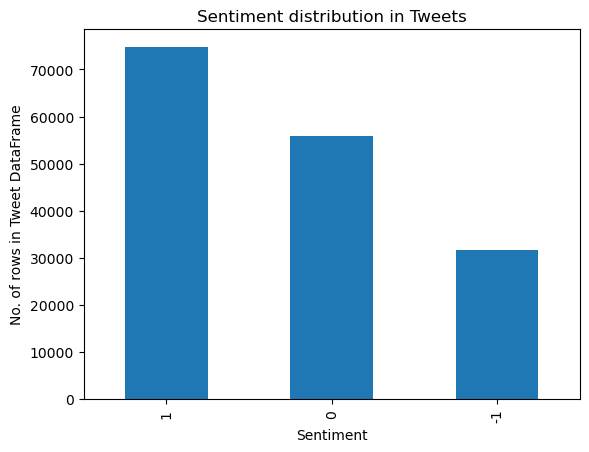

In [53]:
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(tweet['sentiment_numerical']).plot.bar(title="Sentiment distribution in Tweets")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in Tweet DataFrame")
plt.show()

### 5.1 Splitting into Train and Test Sets
<p>Train data ( Subset of data for training ML Model) ~70%</p>
<p>Test data (Subset of data for testing ML Model trained from the train data) ~30%</p>

In [54]:
# Train Test Split Function

def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(tweet[['text', 'favourites_count', 'retweet_count', 'tags',
       'accts', 'entity_text', 'sentiment', 'polarity', 'vader_prediction',
       'vader_prediction_polarity', 'tokenized_text',
       'stemmed_tokens']], tweet['sentiment_numerical'], shuffle=shuffle_state, test_size=test_size, random_state=15)
    
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    
    print(type(X_train))
    print(type(Y_train))
    
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    
#     print(X_train.head())
    
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(tweet)

Value counts for Train sentiments
 1    52136
 0    39408
-1    22136
Name: sentiment_numerical, dtype: int64
Value counts for Test sentiments
 1    22648
 0    16534
-1     9538
Name: sentiment_numerical, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [55]:
# Skip-gram model (sg = 1)

size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

word2vec_model_file = './data/word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(tweet['stemmed_tokens']).values

# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size=size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 71.51939368247986


### Generating Word2Vec Vectors
<p>By navigating through the X train dataset, Word2Vec vectors are produced for each review in the train data. We may obtain the word embedding vectors for those words by applying the model to each word in the review. We will use an implementation that takes the average of all the word vectors in a sentence to represent a sentence from our dataset. A CSV file is used to hold these vectors. We can generate this directly in a data frame, but if there are many data, it is advisable to write to a file as the vector is created so that you can pick up where the function left off if it ever breaks. </p>

In [56]:
# Store the vectors for train data in following file
word2vec_filename = './data/train_word2vec.csv'

# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model.wv[token] for token in row['stemmed_tokens']], axis=0)).tolist()
        
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        
        word2vec_file.write(line1)
        word2vec_file.write('\n')

### Training Sentiment Classification Model using Word2Vec Vectors
<p>We load the Word2Vec vectors into a data frame once they are prepared for training. Here, sentiment classification is carried out using DecisionTreeClassifier. Decision tree classifier is a supervised machine learning algorithm. The decision tree classifier class in this example is implemented using the scikit-learn package. The input feature vectors are compared to the feelings in the train data using the fit function.</p>

In [57]:
# Load from the filename
word2vec_df = pd.read_csv(word2vec_filename)

# Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()

# Fit the model
clf_decision_word2vec.fit(word2vec_df, Y_train['sentiment_numerical'])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 219.2867624759674


### Testing the Model

In [58]:
test_features_word2vec = []

for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model.wv[token] for token in row['stemmed_tokens']], axis=0)
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))

test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)
print(classification_report(Y_test['sentiment_numerical'],test_predictions_word2vec))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      9538
           0       0.34      1.00      0.51     16534
           1       0.00      0.00      0.00     22648

    accuracy                           0.34     48720
   macro avg       0.11      0.33      0.17     48720
weighted avg       0.12      0.34      0.17     48720



<p>Our model got the accuracy of 34% which is very low.</p>
<p>We can try to improve the accuracy with BOW Classification and TFIDF Classification in the future.</p>